In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import ktrain
from ktrain import vision as vis

Using TensorFlow backend.


In [2]:
# build a regular expression that extracts class from file name
import re
p = re.compile(r'([^/]+)_\d+.jpg$')
r = p.search('/hello/world/beagle_007.jpg')
r.group(1)

'beagle'

In [3]:
# use the vision.images_from_fname to load the dataset and extract class names from file names
# Don't forget to do the following
# 1. Download data from here:  https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz
# 2. set DATADIR to the extracted folder
DATADIR='data/oxford-iiit-pet/images'
data_aug = vis.get_data_aug(horizontal_flip=True, shear_range=0.2) # additions to default data augmentation
(train_data, val_data, preproc) = vis.images_from_fname( 
                                                          DATADIR,
                                                           pattern = r'([^/]+)_\d+.jpg$',
                                                           data_aug = data_aug, 
                                                           target_size=(299,299), color_mode='rgb', val_pct=0.2)

Found 7390 images belonging to 1 classes.
Found 37 classes: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
y shape: (7390,37)
Found 5852 images.
Found 1538 images.


In [4]:
# build a pre-trained ResNet50 model
# Note that we have used the pt_fc and pt_ps arguments to include
# an extra Dense layer (and dropout) before final dropout and final Dense layer
model = vis.image_classifier('pretrained_resnet50', train_data, val_data, pt_fc=[512], pt_ps=[0.25])

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
pretrained_resnet50 model created.


In [5]:
# wrap model and data in Learner object
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

In [6]:
learner.print_layers()

0 (trainable=False) : <keras.engine.input_layer.InputLayer object at 0x7effa9315d30>
1 (trainable=False) : <keras.layers.convolutional.ZeroPadding2D object at 0x7effeb828828>
2 (trainable=False) : <keras.layers.convolutional.Conv2D object at 0x7effeb809d30>
3 (trainable=False) : <keras.layers.normalization.BatchNormalization object at 0x7f000bed1eb8>
4 (trainable=False) : <keras.layers.core.Activation object at 0x7f000bed1cf8>
5 (trainable=False) : <keras.layers.convolutional.ZeroPadding2D object at 0x7effa92d7668>
6 (trainable=False) : <keras.layers.pooling.MaxPooling2D object at 0x7effa92d7470>
7 (trainable=False) : <keras.layers.convolutional.Conv2D object at 0x7f000beedf60>
8 (trainable=False) : <keras.layers.normalization.BatchNormalization object at 0x7f000a3d5748>
9 (trainable=False) : <keras.layers.core.Activation object at 0x7f000a3d5eb8>
10 (trainable=False) : <keras.layers.convolutional.Conv2D object at 0x7f000a381b70>
11 (trainable=False) : <keras.layers.normalization.Batch

In [7]:
# find a good learning rate
learner.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
92/92 [==============================] - 32s 349ms/step - loss: 7.2042 - acc: 0.0324
Epoch 2/5
92/92 [==============================] - 26s 278ms/step - loss: 3.6258 - acc: 0.1726
Epoch 3/5
92/92 [==============================] - 26s 286ms/step - loss: 2.7193 - acc: 0.3370
Epoch 4/5
92/92 [==============================] - 25s 275ms/step - loss: 4.1443 - acc: 0.0447
Epoch 5/5
73/92 [======================>.......] - ETA: 5s - loss: 12.4748 - acc: 0.0276

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


In [8]:
learner.lr_plot()

For demonstration purposes, we use `autofit` to train, which employs a triangular learning rate policy with `epochs=20` and `reduce_on_plateau=2`.  You may choose to try something different.

In [12]:
# train for 20 epochs and reduce LR after no improvement for 2 epochs
learner.autofit(5e-4, 20, reduce_on_plateau=2)



begin training using triangular learning rate policy with max lr of 0.0005...
Epoch 1/20
92/92 [==============================] - 32s 350ms/step - loss: 3.0374 - acc: 0.2756 - val_loss: 0.9356 - val_acc: 0.7035
Epoch 2/20
92/92 [==============================] - 30s 329ms/step - loss: 1.9647 - acc: 0.4609 - val_loss: 0.6550 - val_acc: 0.8032
Epoch 3/20
92/92 [==============================] - 31s 336ms/step - loss: 1.6151 - acc: 0.5372 - val_loss: 0.5620 - val_acc: 0.8373
Epoch 4/20
92/92 [==============================] - 31s 334ms/step - loss: 1.3980 - acc: 0.5919 - val_loss: 0.4786 - val_acc: 0.8574
Epoch 5/20
92/92 [==============================] - 31s 334ms/step - loss: 1.2780 - acc: 0.6299 - val_loss: 0.4058 - val_acc: 0.8701
Epoch 6/20
92/92 [==============================] - 30s 326ms/step - loss: 1.2129 - acc: 0.6414 - val_loss: 0.4124 - val_acc: 0.8809
Epoch 7/20
92/92 [==============================] - 31s 339ms/step - loss: 1.0986 - acc: 0.6736 - val_loss: 0.4517 - val_a

In [43]:
# get a Predictor instance that wraps model and Preprocessor object
predictor = ktrain.get_predictor(learner.model, preproc)

In [46]:
# get some random file names of images
!!ls {DATADIR} | sort -R |head -10

['Ragdoll_186.jpg',
 'leonberger_73.jpg',
 'great_pyrenees_11.jpg',
 'Persian_101.jpg',
 'samoyed_76.jpg',
 'beagle_28.jpg',
 'keeshond_25.jpg',
 'staffordshire_bull_terrier_8.jpg',
 'newfoundland_146.jpg',
 'japanese_chin_87.jpg']

In [47]:
# visualize ragdoll
vis.show_image(DATADIR+'/Ragdoll_186.jpg')

In [48]:
# correctly predict ragdoll
predictor.predict_filename(DATADIR+'/Ragdoll_186.jpg')

['Ragdoll']

In [49]:
# visualize a staffordshire bull terrier
vis.show_image(DATADIR+'/staffordshire_bull_terrier_8.jpg')

In [50]:
# correctly predict the staffordshire bull terrier
predictor.predict_filename(DATADIR+'/staffordshire_bull_terrier_8.jpg')

['staffordshire_bull_terrier']

In [51]:
# save predictor object for later use
predictor.save('/tmp/pet_detector')

In [52]:
# load predictor object
predictor = ktrain.load_predictor('/tmp/pet_detector')

In [54]:
# predict a Newfoundland
predictor.predict_filename(DATADIR+'/newfoundland_146.jpg')

['newfoundland']

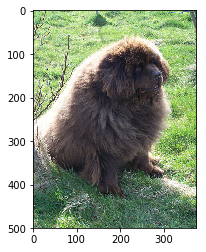

In [55]:
# let's look at the dog we correctly predicted - it's cute
vis.show_image(DATADIR+'/newfoundland_146.jpg')